In [66]:
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
# Algorithms
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Lasso
from xgboost import XGBRegressor
# preproceessing
from model_transformers import FeaturesInteractions,SkewTransformer,ZeroThreshold

from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split,cross_validate,cross_val_score
from sklearn.model_selection import RepeatedKFold,GridSearchCV,KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler,MinMaxScaler

from sklearn.externals import joblib

# sklearn classes
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone


In [2]:
#dataframe final
df_final = pd.read_csv("../data/DF_train15noChangeContact_skempiAB_modeller_final.csv",index_col=0)


pdb_names = df_final.index
features_names = df_final.drop('ddG_exp',axis=1).columns
df_final.shape

(1392, 78)

In [3]:
# Split train and independent test data

X_train, X_test, y_train, y_test = train_test_split(df_final.drop('ddG_exp',axis=1), df_final['ddG_exp'], 
                                                    test_size=0.2, random_state=13)     

# join train data for Exploratory analisis of training data
train = X_train.join(y_train)

# Drop outliers
train = train.drop(train[(train['van_der_waals_change']>3)].index)
train = train.drop(train[(train['dg_change'].abs()>8)].index)

y_train = train['ddG_exp']
X_train = train.drop('ddG_exp',axis=1)

In [4]:
full_data = pd.concat([X_train, X_test])
y_full = pd.concat([y_train, y_test])

# Modelling

#### Crossvalidation strategy

In [ ]:
# index of best scores
rmse_bestCV_test_index = grid1.cv_results_['mean_test_neg_mean_squared_error'].argmax()
rmse_bestCV_train_index = grid1.cv_results_['mean_train_neg_mean_squared_error'].argmax()
r2_bestCV_test_index = grid1.cv_results_['mean_test_r2'].argmax()
r2_bestCV_train_index = grid1.cv_results_['mean_train_r2'].argmax()
# scores
rmse_bestCV_test_score = grid1.cv_results_['mean_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_test_std = grid1.cv_results_['std_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_train_score = grid1.cv_results_['mean_train_neg_mean_squared_error'][rmse_bestCV_train_index]
rmse_bestCV_train_std = grid1.cv_results_['std_train_neg_mean_squared_error'][rmse_bestCV_train_index]

r2_bestCV_test_score = grid1.cv_results_['mean_test_r2'][r2_bestCV_test_index]
r2_bestCV_test_std = grid1.cv_results_['std_test_r2'][r2_bestCV_test_index]
r2_bestCV_train_score = grid1.cv_results_['mean_train_r2'][r2_bestCV_train_index]
r2_bestCV_train_std = grid1.cv_results_['std_train_r2'][r2_bestCV_train_index]

print('CV test RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_test_score),np.sqrt(rmse_bestCV_test_std)))
print('CV train RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_train_score),np.sqrt(rmse_bestCV_train_std)))
print('DIFF RMSE {}'.format(np.sqrt(-rmse_bestCV_test_score)-np.sqrt(-rmse_bestCV_train_score)))
print('CV test r2 {:f} +/- {:f}'.format(r2_bestCV_test_score,r2_bestCV_test_std))
print('CV train r2 {:f} +/- {:f}'.format(r2_bestCV_train_score,r2_bestCV_train_std))

print(r2_bestCV_train_score-r2_bestCV_test_score)
y_test_pred = grid1.best_estimator_.predict(X_test)
y_train_pred = grid1.best_estimator_.predict(X_train)
print("\nRMSE for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)))
print("RMSE for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)))
print("pearson corr  test {:f}".format(np.corrcoef(y_test_pred,y_test.values.ravel())[0][1]))
print("pearson corr  train {:f}".format(np.corrcoef(y_train_pred,y_train.values.ravel())[0][1]))

print('R2 test',r2_score(y_test,y_test_pred))
print('R2 train',r2_score(y_train,y_train_pred))

In [51]:
def cv_results(cv_object):
    
    # scores
    rmse_train_cv = np.sqrt(-cv_object["train_neg_mean_squared_error"])
    rmse_test_cv = np.sqrt(-cv_object["test_neg_mean_squared_error"])
    r2_train_cv = cv_object["train_r2"]
    r2_test_cv = cv_object["test_r2"]
    
    print("RMSE train CV: {:.4f} ({:.4f})".format(rmse_train_cv.mean(),rmse_train_cv.std()))
    print("RMSE test CV: {:.4f} ({:.4f})".format(rmse_test_cv.mean(),rmse_test_cv.std()))
    print('DIFF RMSE {}\n'.format(rmse_test_cv.mean()-rmse_train_cv.mean()))

    print("r2 train CV: {:.4f} ({:.4f})".format(r2_train_cv.mean(),r2_train_cv.std()))
    print("r2 test CV: {:.4f} ({:.4f})".format(r2_test_cv.mean(),r2_test_cv.std()))
    print('DIFF RMSE {}\n'.format(r2_test_cv.mean()-r2_train_cv.mean()))
    
def test_results(fitted_estimator,Xtest,Ytest):
    y_test_pred = fitted_estimator.predict(Xtest)
    #y_train_pred = fitted_estimator.predict(Xtrain)
    
    print("RMSE test: {}".format(np.round(np.sqrt(mean_squared_error(Ytest, y_test_pred)), 2)))

    print('r2 test',r2_score(Ytest,y_test_pred))
    #print('r2 train',r2_score(Ytrain,y_train_pred))
    
    print("Pearson corr test {:f}".format(np.corrcoef(y_test_pred,Ytest.values.ravel())[0][1]))
    

In [45]:
#Validation function
n_folds = 10

def evaluating(model,Xtrain,Ytarget):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(Xtrain.values)
    #rkf = RepeatedKFold(n_splits=10,n_repeats=10,random_state=13)
    cvscore = cross_validate(model, Xtrain, Ytarget, scoring=["r2","neg_mean_squared_error"],
                             cv = kf,verbose=1,n_jobs=-1,return_train_score=True,return_estimator=True)
    return cvscore

def evaluating2(model,Xtrain,Ytarget):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(Xtrain.values)
    #rkf = RepeatedKFold(n_splits=10,n_repeats=10,random_state=13)
    cvscore = cross_validate(model, Xtrain, Ytarget, scoring=["r2","neg_mean_squared_error"],
                             cv = kf,verbose=1,n_jobs=-1,return_train_score=True,return_estimator=True)
    return cvscore

In [46]:
# preprocess pipeline steps
#steps pipeline
interactions = FeaturesInteractions(interaction1=X_train.columns[:15].tolist(),interaction2="van_der_waals_change")
skewness = SkewTransformer(threshold=0.6,method='quantile')
zeroth = ZeroThreshold(threshold=90.)

In [81]:
GradientBoostingRegressor?

#### algorithms

In [116]:
#lasso model
lasso = make_pipeline(interactions,skewness,zeroth,MinMaxScaler(),
                      Lasso(alpha=0.001,normalize=True,fit_intercept=True,random_state=1))
# svr polynomial kernel
svrP = make_pipeline(interactions,skewness,zeroth,MinMaxScaler(),
                      SVR(C=1,degree=2,epsilon=0.4,gamma=0.5,kernel='poly'))

svrRBF = make_pipeline(interactions,skewness,zeroth,MinMaxScaler(),
                      SVR(C=2.5,epsilon=0.5,gamma=0.5,kernel='rbf'))

gbt = make_pipeline(interactions,skewness,zeroth,
                   GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05,
                                   max_depth=8, max_features='sqrt',
                                   min_samples_leaf=8, min_samples_split=2, 
                                   loss='huber', random_state =5,subsample=0.6,alpha=0.7))

xgbr = make_pipeline(interactions,skewness,zeroth,
                   XGBRegressor(colsample_bytree=0.6, gamma=0, 
                             learning_rate=0.07, max_depth=8, 
                             min_child_weight=20, n_estimators=1000,
                             reg_alpha=0.000005, reg_lambda=200,
                             subsample=0.9,random_state =7, nthread = -1))


In [115]:
XGBRegressor?

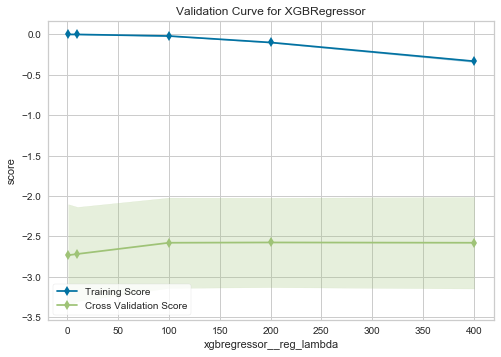

3


In [113]:
import numpy as np

from yellowbrick.model_selection import ValidationCurve

#1)
#2)
#3) Crear pipeline

viz = ValidationCurve(
    xgbr, njobs=-1,param_name="xgbregressor__reg_lambda",
    param_range=[1,10,100,200,400], cv=10, scoring="neg_mean_squared_error",n_jobs=-1)
#plt.ylim(0,0.6)
# Fit and poof the visualizer
viz.fit(X_train, y_train)
viz.poof()
print(viz.test_scores_mean_.argmax())

In [77]:
np.sqrt(-viz.test_scores_mean_)

array([1.58978938, 1.58838006, 1.5870186 , 1.58659171, 1.5865904 ])

#### Base model scores

In [52]:
print('Lasso Model Evaluation')
lassocv = evaluating(lasso,X_train,y_train)
cv_results(lassocv)

lasso_model = lasso.fit(X_train,y_train)
test_results(lasso_model,X_test,y_test)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    2.7s finished


RMSE train CV: 1.6844 (0.0199)
RMSE test CV: 1.7245 (0.1926)
DIFF RMSE 0.04010925875432436

r2 train CV: 0.1972 (0.0106)
r2 test CV: 0.1451 (0.0632)
DIFF RMSE -0.05203947250971952

RMSE test: 1.72
r2 test 0.255501865606795
Pearson corr test 0.533188


In [117]:
print('XGBRegressor Model Evaluation')
xgbrcv = evaluating(xgbr,X_train,y_train)
cv_results(xgbrcv)

xgbr_model = xgbr.fit(X_train,y_train)
test_results(xgbr_model,X_test,y_test)


XGBRegressor Model Evaluation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.8s finished


RMSE train CV: 0.3163 (0.0064)
RMSE test CV: 1.5952 (0.1729)
DIFF RMSE 1.2789593926118417

r2 train CV: 0.9717 (0.0008)
r2 test CV: 0.2669 (0.0673)
DIFF RMSE -0.7047906015142127

RMSE test: 1.63
r2 test 0.3335486540403495
Pearson corr test 0.578549


In [54]:
print('SVR polynomial Model Evaluation')
svrPcv = evaluating(svrP,X_train,y_train)
cv_results(svrPcv)

svrP_model = xgbr.fit(X_train,y_train)
test_results(svrP_model,X_test,y_test)

SVR polynomial Model Evaluation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    1.7s finished


RMSE train CV: 1.5431 (0.0177)
RMSE test CV: 1.7132 (0.1863)
DIFF RMSE 0.17010848501651843

r2 train CV: 0.3262 (0.0113)
r2 test CV: 0.1540 (0.0859)
DIFF RMSE -0.17224717942281076

RMSE test: 1.64
r2 test 0.3218545387639137
Pearson corr test 0.590229


In [55]:
print('SVR rbf Model Evaluation')
svrRBFcv = evaluating(svrRBF,X_train,y_train)
cv_results(svrRBFcv)

svrRBF_model = svrRBF.fit(X_train,y_train)
test_results(svrRBF_model,X_test,y_test)

SVR rbf Model Evaluation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    3.0s finished


RMSE train CV: 1.4346 (0.0179)
RMSE test CV: 1.6718 (0.1876)
DIFF RMSE 0.2372212684348758

r2 train CV: 0.4176 (0.0093)
r2 test CV: 0.1965 (0.0544)
DIFF RMSE -0.22110350912096322

RMSE test: 1.72
r2 test 0.25833886420090024
Pearson corr test 0.521817


In [101]:
print('GradientBoostingRegressor Model Evaluation')
gbtcv = evaluating(gbt,X_train,y_train)
cv_results(gbtcv)

gbt_model = gbt.fit(X_train,y_train)
test_results(gbt_model,X_test,y_test)

GradientBoostingRegressor Model Evaluation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   14.1s finished


RMSE train CV: 0.7067 (0.0088)
RMSE test CV: 1.5883 (0.1880)
DIFF RMSE 0.8816176739729296

r2 train CV: 0.8587 (0.0032)
r2 test CV: 0.2756 (0.0576)
DIFF RMSE -0.5831130722984809

RMSE test: 1.62
r2 test 0.33779241686393613
Pearson corr test 0.590803


In [ ]:
RMSE train CV: 0.7123 (0.0179)
RMSE test CV: 1.6053 (0.1711)
DIFF RMSE 0.8930631120106576

r2 train CV: 0.8564 (0.0067)
r2 test CV: 0.2576 (0.0620)
DIFF RMSE -0.5987430199132573

RMSE test: 1.61
r2 test 0.35009451747917697
Pearson corr test 0.601212

In [118]:

class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [119]:
print('Averaged Models Evaluation')
averaged_models = AveragingModels(models = (gbt, svrP,xgbr,svrRBF, lasso))

averaged_models_cv = evaluating(averaged_models,X_train,y_train)
cv_results(averaged_models_cv)

averaged_models_model = averaged_models.fit(X_train,y_train)
test_results(averaged_models_model,X_test,y_test)

Averaged Models Evaluation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   25.1s finished


RMSE train CV: 1.0901 (0.0133)
RMSE test CV: 1.6149 (0.1852)
DIFF RMSE 0.5248280604564408

r2 train CV: 0.6637 (0.0054)
r2 test CV: 0.2503 (0.0620)
DIFF RMSE -0.41343578405109527

RMSE test: 1.63
r2 test 0.32956477542995066
Pearson corr test 0.603845


In [120]:
final_avg = averaged_models.fit(full_data,y_full)
from sklearn.externals import joblib

# save final model

joblib.dump(final_avg, 'avg_models_FINAL.pkl')

['avg_models_FINAL.pkl']

In [121]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X.iloc[train_index], y.iloc[train_index])
                y_pred = instance.predict(X.iloc[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)


In [123]:
lassoMeta = make_pipeline(MinMaxScaler(), Lasso(alpha =0.001, random_state=1,normalize=True,fit_intercept=True))
svrMeta = make_pipeline(make_pipeline(MinMaxScaler(),
                      SVR(C=1,degree=2,epsilon=0.4,gamma=0.5,kernel='poly')))

xgbMeta = make_pipeline(make_pipeline(XGBRegressor(colsample_bytree=0.6, gamma=0, 
                             learning_rate=0.07, max_depth=8, 
                             min_child_weight=20, n_estimators=1000,
                             reg_alpha=0.000005, reg_lambda=200,
                             subsample=0.9,random_state =7, nthread = -1)))

# GradientBoostingRegressor(n_estimators=1000, learning_rate=0.05,
#                                    max_depth=8, max_features='sqrt',
#                                    min_samples_leaf=8, min_samples_split=2, 
#                                    loss='huber', random_state =5,subsample=0.6,alpha=0.7)

In [126]:
stacked_averaged_models = StackingAveragedModels(base_models = (gbt, svrP,svrRBF,xgbr),
                                                 meta_model = svrMeta)

In [127]:
print('Averaged Stacked Models Evaluation')

stacked_averaged_models_cv = evaluating(stacked_averaged_models,X_train,y_train)
cv_results(stacked_averaged_models_cv)

stacked_averaged_models_model = stacked_averaged_models.fit(X_train,y_train)
test_results(stacked_averaged_models_model,X_test,y_test)

Averaged Stacked Models Evaluation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.8min finished


RMSE train CV: 1.0710 (0.0325)
RMSE test CV: 1.6200 (0.1764)
DIFF RMSE 0.5489581757355955

r2 train CV: 0.6752 (0.0179)
r2 test CV: 0.2452 (0.0525)
DIFF RMSE -0.43001800489044917

RMSE test: 1.64
r2 test 0.3222673596919453
Pearson corr test 0.607882


In [128]:
final_stacked_averaged_models = stacked_averaged_models.fit(full_data,y_full)

In [129]:
from sklearn.externals import joblib

# save final model

joblib.dump(final_stacked_averaged_models, 'stacked_averaged_models_FINAL.pkl')

['stacked_averaged_models_FINAL.pkl']